# Simple Model Cavity **Gridap version**

Writen by: Oscar Reula (oreula@gmail.com)

This code is used to compute the resonant frequencies and eigenvectors of a cavity. The model is 2-dimensional, that is it corresponds to infinite long structures in the  ẑ direction. 
This restriction is mainly due to have a code that can run in home computers in very short time.

First the theory: we need to solve the following eigenfuntion problem: 

$\nabla \cdot \nabla u  = \lambda u \quad\quad\text{ in }\Omega$

$u = 0 \text{ on } \partial\Omega$

Where $\Omega$ is some 2-dimensional region. 

In order to use finite elements we need to express the problem as a weak one:

$$
\int_{\Omega} \nabla u\,\cdot \nabla v\, {\rm d} x
= \lambda \int_{\Omega} u \cdot v\, {\rm d} x \quad \forall  v \in H^1_0(\Omega),
$$



We shall incorporate a simple, known, case which we shall use to test the implementation, namely:

$\nabla \cdot \nabla u  = \lambda u \quad\quad\text{ in } \Omega \quad\quad\quad
\Omega = (0,\pi)\times(0,\pi)$

For this case we know the solutions: 

$u_{n,m}(x,y) = \sin(n x)\sin(m y), \quad \lambda = m^2 + n^2,$ $\quad \lambda = 2, 5, 5, 8, 10, 10, 13, 13, 17, 17, 18, \dots$

We use this case to check that what we are doing is correct. 

Part of this code is addapted from: https://gist.github.com/Balaje/102485bb14ec6daf677f938fbd8f3ebb

### Status

The normal Dirichlet problem is working.

In [1]:
using Gridap
using GridapMakie, GLMakie
GLMakie.activate!(inline=true)
using FileIO
#using Plots
#mkdir("models")
#mkdir("images")
using GridapGmsh
#using gmsh
using LinearAlgebra
using SparseArrays
using SuiteSparse
using Arpack

In [18]:
dirichlet = true # Dirichlet boundary condition
neumann = false # Neumann boundary condition



test = false # test with no leaking, just to check the code.
rectangle = false # rectangle with leaking (parameter a)
square_circle = false
circle_circle = false
open_cavity = false # square with an interior cavity with an opening. 
                    # the cavity has no leaking except for the hole. 
                    # the outer part has Dirichlet.

test = true
#rectangle = true
#square_circle = true
#circle_circle = true
#open_cavity = true


true

In [19]:
if test || rectangle 
    L=1.0
    asymmetry = 1.0 # si diferente de UNO da una asimetría y los autovalores dejan de ser degenerados.
    side_x = L*pi
    side_y = L*pi*asymmetry
    @show l = 50 #number of elements in the mesh
    @show domain = (0.0, side_x, 0.0, side_y)
    model = CartesianDiscreteModel(domain, (l,l))
    boundary_tags= ["boundary"]
    if dirichlet  
        dirichlet_tags= ["boundary"] 
        dirichlet_values = [0.0];
    end

elseif square_circle
    displacement = 0.0 
    h = 1.0/10.0
    p = (π, π, 0.5*π, 0.5*π + displacement, 0.15*π, h) # for square_circle (Length_x, Length_y, circle_center_x, circle_center_y, radious)
    model = GmshDiscreteModel("models/square_circle.msh")
    boundary_tags = ["circle", "ext"]
    if dirichlet 
        dirichlet_tags= ["circle","ext"] 
        dirichlet_values = [0.0,0.0]
    end 

elseif circle_circle
    h = 1.0/10.0
    p = (0.0, 0.0, 0.5*π, 1.5*π, h) # for circle_circle (cy_center_x, cy_center_y, cy_inner_radious, cy_outer_radious)
    model = GmshDiscreteModel("models/circle_circle.msh")
    boundary_tags = ["inner","outer"]
    if dirichlet 
        dirichlet_tags=["inner","outer"]
        dirichlet_values = [0.0,0.0];
    end
    

elseif open_cavity
    L=1.0*pi
    ll = 0.4
    side_x = L
    side_y = L
    small_x = ll*L
    small_y = ll*L
    openning = 0.05*L
    thikness = 0.1*L
    model = GmshDiscreteModel("models/cavity_box.msh") 
    boundary_tags= ["int","ext"]
    if dirichlet 
        dirichlet_tags= ["int","ext"] 
        dirichlet_values = [0.0,0.0];
    end 
end

l = 50 = 50
domain = (0.0, side_x, 0.0, side_y) = (0.0, 3.141592653589793, 0.0, 3.141592653589793)


1-element Vector{Float64}:
 0.0

In [24]:
model

CartesianDiscreteModel()

In [5]:
#=
if load_mesh = false

if test: 
    mesh = RectangleMesh(Point(0, 0), Point(side_x, side_y), 100, 100)
if rectangle:
    mesh = RectangleMesh(Point(0, 0), Point(side_x, side_y), 20, 20)
if open_cavity:
    big_square = Rectangle(Point(0., 0.), Point(side_x,side_y))
    
    triangle_vertices = [
    Point((side_x + openning)/2., (side_y - small_y)/2.),
    Point((side_x + small_x )/2., (side_y - small_y)/2.),
    Point((side_x + small_x )/2., (side_y + small_y)/2.),
    Point((side_x - small_x )/2., (side_y + small_y)/2.),
    Point((side_x - small_x )/2., (side_y - small_y)/2.),
    Point((side_x - openning)/2., (side_y - small_y)/2.),
    Point((side_x - openning)/2., (side_y - small_y + thikness)/2.),
    Point((side_x - small_x + thikness)/2., (side_y - small_y + thikness)/2.),
    Point((side_x - small_x + thikness)/2., (side_y + small_y - thikness)/2.),
    Point((side_x + small_x - thikness)/2., (side_y + small_y - thikness)/2.),
    Point((side_x + small_x - thikness)/2., (side_y - small_y + thikness)/2.),
    Point((side_x + openning)/2., (side_y - small_y + thikness)/2.)
    ]
    
    small_cavity = Polygon(triangle_vertices)
    
    domain = big_square - small_cavity
#    domain = small_cavity
    mesh = generate_mesh(domain,42)
    
coords = mesh.coordinates()
mpl.figure(figsize=(10,10))
triplot(coords[:,0], coords[:,1], triangles=mesh.cells())
#print mesh.num_cells()
show()

end

if load_mesh
    model = GmshDiscreteModel("models/$grid_type.msh")
else
    model = make_model(grid_type, p)
    save("models/$grid_type.msh", "mesh", model)
end
=#

In [25]:
Ω = Triangulation(model)
degree = 3
dΩ = Measure(Ω,degree)

GenericMeasure()

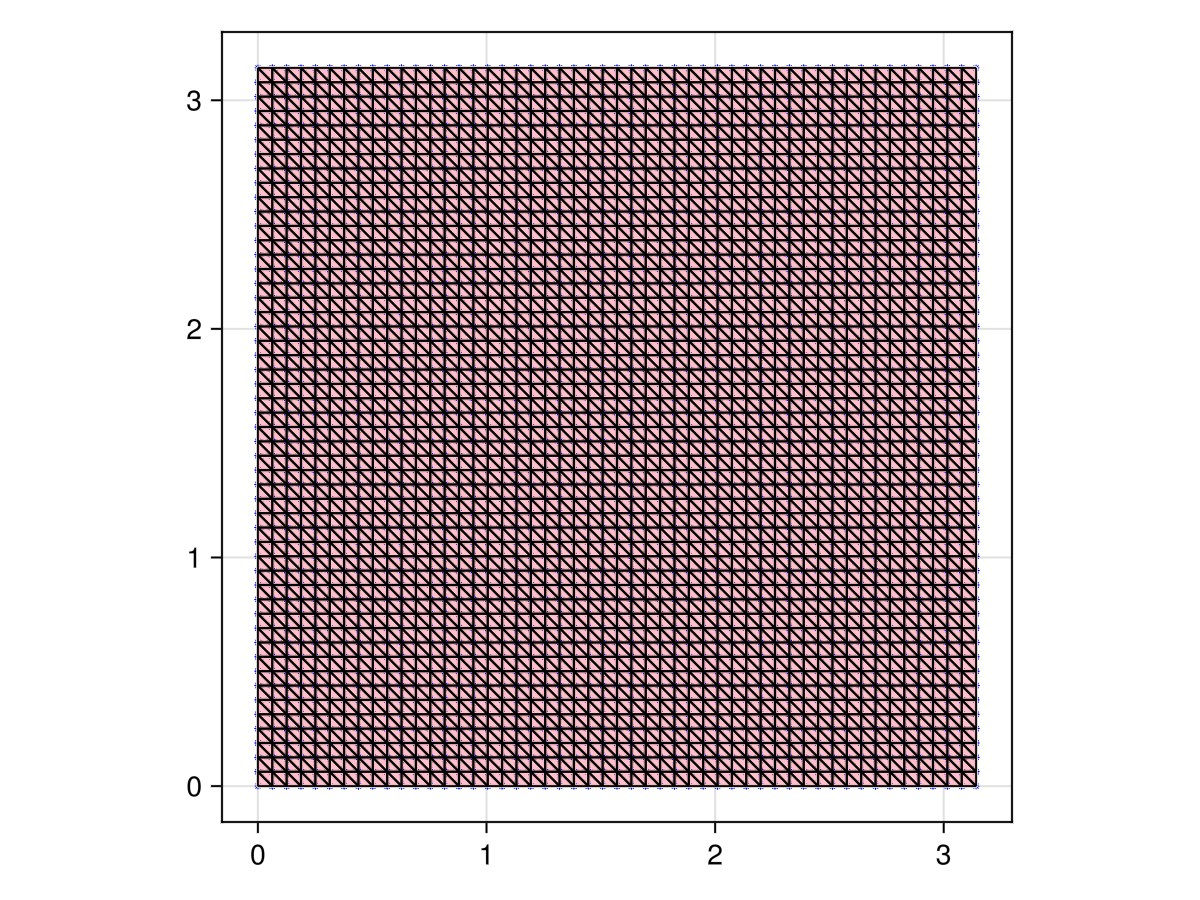

In [7]:
fig, ax = plot(Ω)
ax.aspect = AxisAspect(1) # this makes the region with fixed aspect, so it might not give the correct ratios
wireframe!(Ω, color=:black, linewidth=1)
scatter!(Ω, marker=:star8, markersize=4, color=:blue)
fig

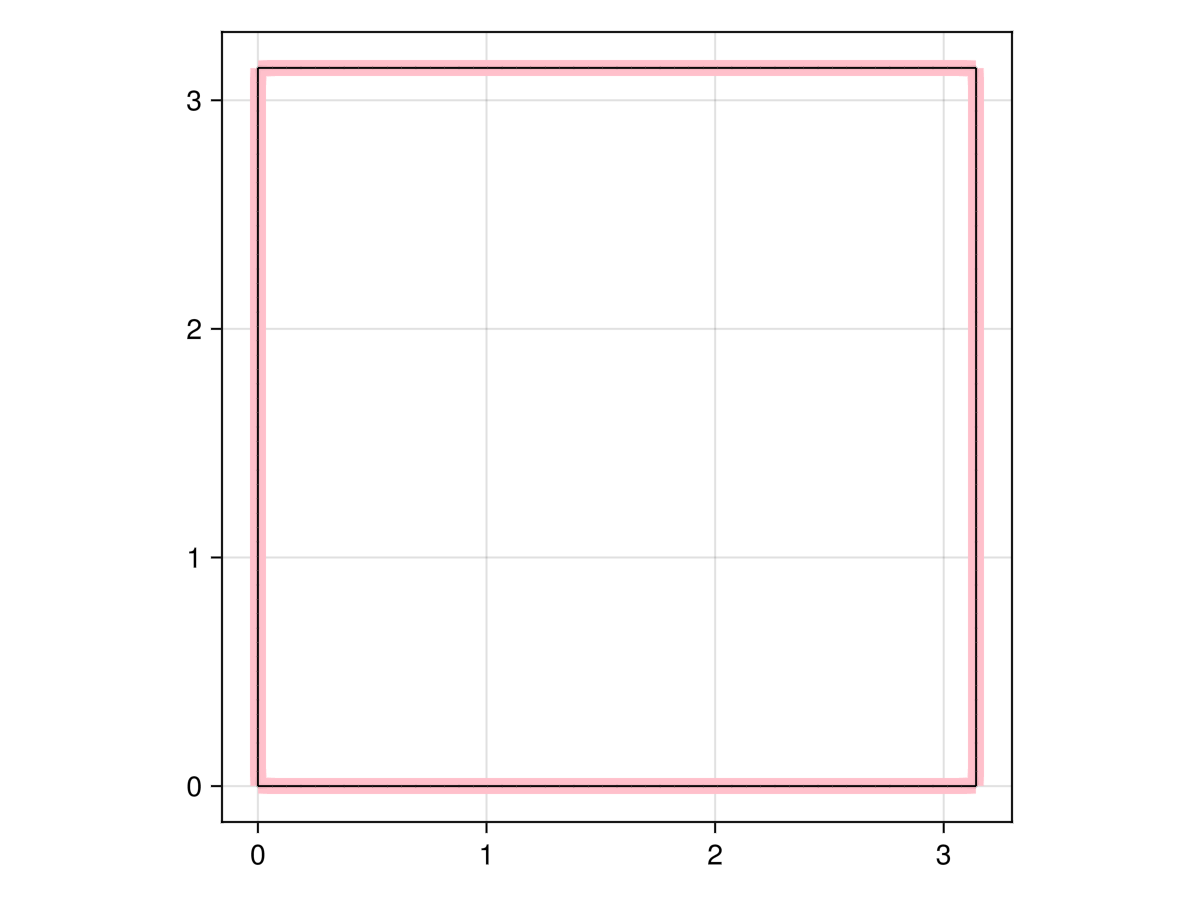

In [26]:
Γ = BoundaryTriangulation(model,tags=boundary_tags)
dΓ = Measure(Γ,degree)
fig, ax = plot(Γ, linewidth=8)
ax.aspect = AxisAspect(1)
wireframe!(Γ, color=:black, linewidth=1)
fig

In [27]:
order = 2
reffe = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags)
U = TrialFESpace(V,dirichlet_values)


TrialFESpace()

In [28]:
a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
m(u,v) = ∫(u*v)dΩ


m (generic function with 1 method)

In [29]:
include("eigen.jl")

solve (generic function with 1 method)

In [30]:
sigma = 10
nev = 80 # number of eigenvalues asked to evaluate.
prob = EigenProblem(a, m, U, V; nev = nev, sigma = sigma)
ξ, uₕs = solve(prob);

In [31]:
ξ

80-element Vector{ComplexF64}:
 10.000031537383578 - 7.35915057490372e-19im
 10.000031537383595 - 1.2463174532118836e-19im
  8.000005536448239 - 1.8164101000236402e-9im
 13.000034261203153 + 5.40557205422209e-10im
 13.000034262249144 - 2.1396344236313827e-14im
  5.000002811430816 - 2.798062449594286e-13im
  5.000002809586482 + 8.322298767527987e-10im
  17.00017670936943 + 3.573348972394079e-10im
 17.000176709764034 - 3.86493680372173e-15im
 2.0000000856026707 - 1.5109049990505821e-9im
                    ⋮
 104.04232783086266 + 1.0125603861868741e-10im
 104.04232783087507 + 6.297080655691616e-15im
 106.02325961596367 - 1.0500597192243043e-14im
 106.02325961617416 + 2.1122943517721455e-10im
 109.04235655681215 + 4.1826744617034816e-11im
 109.04235655682754 - 2.789185530513255e-14im
 113.01621983861695 + 1.6816545940006688e-14im
 113.01621983867095 + 3.274493855703382e-10im
 116.04250172917699 - 1.2740500625814388e-12im

In [14]:
n = 9
uₕ = uₕs[n]
fig, ax, plt = plot(Ω, real(uₕ), colormap=:heat)
ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

writevtk(Ω,"Cavity/eigvector_$n",cellfields=["u_real" => real(uₕ), "u_imag" => imag(uₕ)])


UndefVarError: UndefVarError: `uₕs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [15]:
scatter(real(ξ))

UndefVarError: UndefVarError: `ξ` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [16]:
if test 
    [n^2 + m^2 for n = 1:5, m = 1:5]
end

5×5 Matrix{Int64}:
  2   5  10  17  26
  5   8  13  20  29
 10  13  18  25  34
 17  20  25  32  41
 26  29  34  41  50